<b> Описание проекта: </b>
<br>В компании «Мегалайн» — федерального оператора сотовой связи клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.
Проанализируем поведение клиентов, сделаем вывод — какой тариф лучше оставить для дальнейшего развития компании.

### Шаг 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from datetime import datetime
from scipy import stats as st

Для начала импортировал все библиотеки, которые мне понадобятся

In [2]:
users = pd.read_csv('/datasets/users.csv')
calls = pd.read_csv('/datasets/calls.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0) # последовал совету
tariffs = pd.read_csv('/datasets/tariffs.csv')

Подгрузил датасеты 

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


38 пропущенных значений в churn_date, но как мы знаем из описания проекта: churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)

In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


По звонкам у нас все в порядке, пропущенных значений нет

In [5]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Данные об СМСках тоже не имеют пропусков

In [6]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


Интернет-трафик в порядке

In [7]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


Это один из важнейших датаседов для анализа и с ним, благо, все в порякдке.

### Предобработка 

In [8]:
users['churn_date'] = pd.to_datetime(users['churn_date'],format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'],format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'],format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'],format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'],format='%Y-%m-%d')


Столбцы с датами в разных датасетах приведены из строкового в формат даты. Помимо этого был проверен каждый датасет на наличие дубликатов. Дубликатов нет

In [9]:
calls['duration'] = np.ceil(calls['duration'])

In [10]:
internet.head(10)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
5,1000_5,399.97,2018-10-02,1000
6,1000_6,540.08,2018-09-07,1000
7,1000_7,415.70,2018-07-11,1000
8,1000_8,505.40,2018-10-08,1000
9,1000_9,345.54,2018-09-03,1000


#### Подсчеты:

In [11]:
calls['month'] = calls['call_date'].astype('datetime64[M]')
messages['month'] = messages['message_date'].astype('datetime64[M]')
internet['month'] = internet['session_date'].astype('datetime64[M]')


In [12]:
calls = calls.sort_values(by = 'month')
messages = messages.sort_values(by = 'month')
internet = internet.sort_values('month')


Для удобства выполнения подсчетов даты переведены в месяцы и отсортированы по возрастанию

In [13]:
calls_grouped = calls.groupby(['user_id', 'month'])['duration'].agg(['count', 'sum']).reset_index()
calls_grouped.columns = ['user_id', 'month', 'calls_count', 'calls_duration']
messages_grouped = messages.groupby(['user_id','month'])[['id']].agg(['count']).reset_index()
messages_grouped.columns = ['user_id', 'month', 'messages']
internet_grouped = internet.groupby(['user_id','month'])[['mb_used']].agg(['sum']).reset_index()
internet_grouped.columns = ['user_id', 'month', 'mb_used']

In [14]:
internet_grouped['mb_used'] = np.ceil(internet_grouped['mb_used']/1024)
internet_grouped['mb_used'].head(10)

0     3.0
1    23.0
2    14.0
3    14.0
4    15.0
5    15.0
6    15.0
7    10.0
8    18.0
9    14.0
Name: mb_used, dtype: float64

Каждый датасет сгруппирован по идентификационному номеру пользователя и месяцу, и к ним применена соответствующиая функция count и sum

In [15]:
merged_tab = pd.merge(calls_grouped, messages_grouped, how='outer', on=['user_id', 'month'])
merged_tab = pd.merge(merged_tab, internet_grouped, how='outer', on=['user_id', 'month'])
merged_tab

,user_id,month,calls_count,calls_duration,messages,mb_used
0,1000,2018-05-01,22.0,159.0,22.0,3.0
1,1000,2018-06-01,43.0,172.0,60.0,23.0
2,1000,2018-07-01,47.0,340.0,75.0,14.0
3,1000,2018-08-01,52.0,408.0,81.0,14.0
4,1000,2018-09-01,58.0,466.0,57.0,15.0
...,...,...,...,...,...,...
3209,1489,2018-09-01,NaN,NaN,32.0,17.0
3210,1489,2018-10-01,NaN,NaN,21.0,20.0
3211,1489,2018-11-01,NaN,NaN,20.0,18.0
3212,1489,2018-12-01,NaN,NaN,35.0,17.0


Сгрупированные датасеты объединены методом merge, и осталось к таблице добавить город и тарифный план

In [16]:
general_tab = pd.merge(merged_tab, users[['user_id', 'tariff', 'city']], how='left', on=['user_id'])
general_tab

,user_id,month,calls_count,calls_duration,messages,mb_used,tariff,city
0,1000,2018-05-01,22.0,159.0,22.0,3.0,ultra,Краснодар
1,1000,2018-06-01,43.0,172.0,60.0,23.0,ultra,Краснодар
2,1000,2018-07-01,47.0,340.0,75.0,14.0,ultra,Краснодар
3,1000,2018-08-01,52.0,408.0,81.0,14.0,ultra,Краснодар
4,1000,2018-09-01,58.0,466.0,57.0,15.0,ultra,Краснодар
...,...,...,...,...,...,...,...,...
3209,1489,2018-09-01,NaN,NaN,32.0,17.0,smart,Санкт-Петербург
3210,1489,2018-10-01,NaN,NaN,21.0,20.0,smart,Санкт-Петербург
3211,1489,2018-11-01,NaN,NaN,20.0,18.0,smart,Санкт-Петербург
3212,1489,2018-12-01,NaN,NaN,35.0,17.0,smart,Санкт-Петербург


In [17]:
general_tab[['calls_count', 'calls_duration', 'messages', 'mb_used']] = general_tab[['calls_count', 'calls_duration', 'messages', 'mb_used']].fillna(0.0).astype('int')
general_tab

,user_id,month,calls_count,calls_duration,messages,mb_used,tariff,city
0,1000,2018-05-01,22,159,22,3,ultra,Краснодар
1,1000,2018-06-01,43,172,60,23,ultra,Краснодар
2,1000,2018-07-01,47,340,75,14,ultra,Краснодар
3,1000,2018-08-01,52,408,81,14,ultra,Краснодар
4,1000,2018-09-01,58,466,57,15,ultra,Краснодар
...,...,...,...,...,...,...,...,...
3209,1489,2018-09-01,0,0,32,17,smart,Санкт-Петербург
3210,1489,2018-10-01,0,0,21,20,smart,Санкт-Петербург
3211,1489,2018-11-01,0,0,20,18,smart,Санкт-Петербург
3212,1489,2018-12-01,0,0,35,17,smart,Санкт-Петербург


Все пропуски были заполнены нулями в главной таблице, по которой в дальнейшем будет производиться анализ. Начнем с подсчетов

In [18]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [19]:
def users_revenue(row):       
    tariff = tariffs.loc[tariffs['tariff_name'] == row['tariff']]
    # считаем сколько за месяц потратил пользователь исходя из его тарифа
    revenue = 0
    monthly_fee = tariff.iloc[0,3]
    revenue += monthly_fee
    # минуты 
    if row['calls_duration'] > tariff.iloc[0,2]:
        extra_minutes_cost = (row['calls_duration'] - tariff.iloc[0,2]) * tariff.iloc[0,-2]
        revenue += extra_minutes_cost
    # сообщения

    if row['messages'] > tariff.iloc[0,0]:
        extra_message_cost = (row['messages'] - tariff.iloc[0,0]) * tariff.iloc[0,-3]
        revenue += extra_message_cost
     
    # трафик
    if row['mb_used'] > tariff.iloc[0,1]:
        # так как клиент может докупать только гигабайты а не мб, рассчитывается сколько гб докупил пользователь
        # и исходя из этого рассчитаем стоимость доп трафика
        extra_gb_used = np.ceil((row['mb_used'] - tariff.iloc[0,1]) / 1024)
        extra_traffic_cost = extra_gb_used * tariff.iloc[0,-4]
        revenue += extra_traffic_cost

    return revenue


In [20]:
general_tab['earnings'] = general_tab.apply(users_revenue, axis = 1)
general_tab

,user_id,month,calls_count,calls_duration,messages,mb_used,tariff,city,earnings
0,1000,2018-05-01,22,159,22,3,ultra,Краснодар,1950
1,1000,2018-06-01,43,172,60,23,ultra,Краснодар,1950
2,1000,2018-07-01,47,340,75,14,ultra,Краснодар,1950
3,1000,2018-08-01,52,408,81,14,ultra,Краснодар,1950
4,1000,2018-09-01,58,466,57,15,ultra,Краснодар,1950
...,...,...,...,...,...,...,...,...,...
3209,1489,2018-09-01,0,0,32,17,smart,Санкт-Петербург,550
3210,1489,2018-10-01,0,0,21,20,smart,Санкт-Петербург,550
3211,1489,2018-11-01,0,0,20,18,smart,Санкт-Петербург,550
3212,1489,2018-12-01,0,0,35,17,smart,Санкт-Петербург,550


С помощью функции users_revenue была рассчитана выручка с каждого пользователя, которую записали в столбец earnings

#### Выводы

Данные, которые нужно было перевести в формат datetime переведены, а также отсортированы помесячно. Month_name не было использовано, так как сортировка была бы неудобной. Также с помощью функции подсчитана выручка с каждого пользователя. 

### Анализ данных

In [21]:
import warnings
warnings.filterwarnings("ignore")

Импортировал warnings для нормального вывода графиков и гистограмм. 

In [22]:
def filtred_hist(row, column):
    q1 = row[column].quantile(0.25)
    q3 = row[column].quantile(0.75)
    iqr = q3 - q1
    result = (general_tab[column] >= (q1 - 1.5*iqr)) & (general_tab[column] <= (q3 + 1.5*iqr))
    return general_tab.loc[result].boxplot([column], figsize=(15,5))

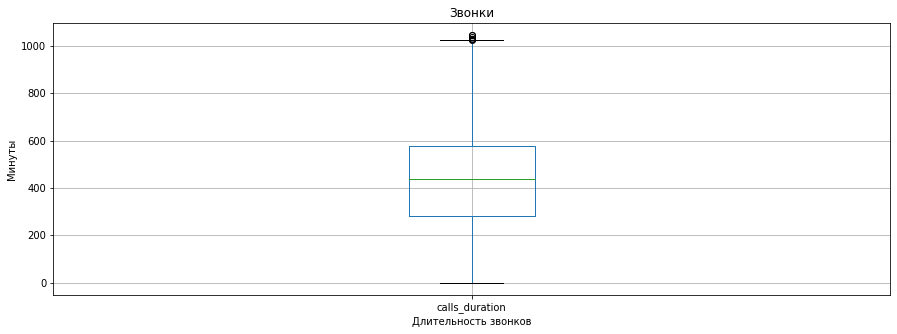

Средняя длительность звонков: 451.24
Медиана длительности звонков: 443.0


In [23]:
filtred_hist(general_tab, 'calls_duration')
plt.xlabel('Длительность звонков')
plt.ylabel('Минуты')
plt.title('Звонки')
plt.show()
print('Средняя длительность звонков:', (round(general_tab['calls_duration'].mean(), 2))) 
print('Медиана длительности звонков:', (round(general_tab['calls_duration'].median(), 2)))

Благодаря функции мы вывели "ящик с усами" для длительности звонков, который оптимально отоброжает данные и избавляет от выбросов. 

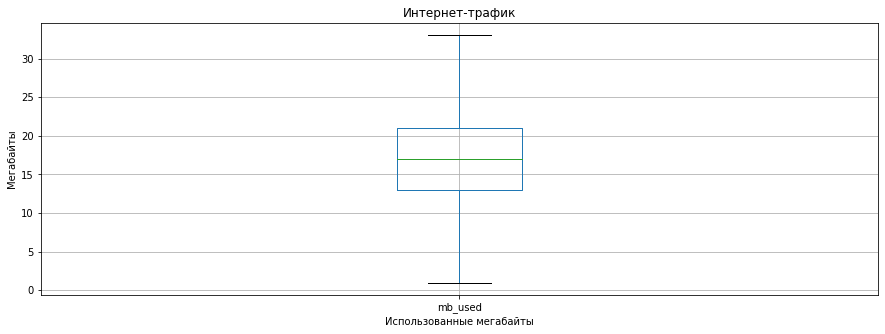

Средняя интернет-трафика: 17.3
Медиана интернет-трафика: 17.0


In [24]:
filtred_hist(general_tab, 'mb_used')
plt.xlabel('Использованные мегабайты')
plt.ylabel('Мегабайты')
plt.title('Интернет-трафик')
plt.show()
print('Средняя интернет-трафика:', (round(general_tab['mb_used'].mean(), 2))) 
print('Медиана интернет-трафика:', (round(general_tab['mb_used'].median(), 2)))

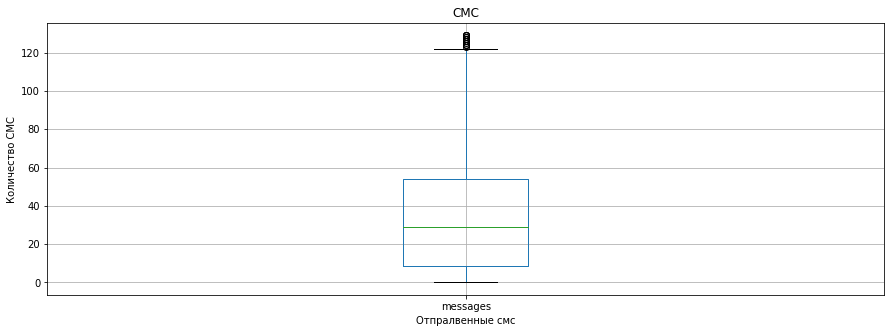

Средняя отправленных СМС: 38.28
Медиана отправеннных СМС: 30.0


In [25]:
filtred_hist(general_tab, 'messages')
plt.xlabel('Отпралвенные смс')
plt.ylabel('Количество СМС')
plt.title('СМС')
plt.show()
print('Средняя отправленных СМС:', (round(general_tab['messages'].mean(), 2))) 
print('Медиана отправеннных СМС:', (round(general_tab['messages'].median(), 2)))

Как мы видим, среднее значнение и медиана у этих данных располагаются довольно близко. Исходя из этих ящиков можно предположить, что выбросы для звонков - это свыше 1000 минут, для интернет-трафика - свыше 34 тысяч гигабайт, и для СМС - свыше 125.

In [26]:
tab_filter = general_tab.query('calls_duration < 1000 and mb_used < 34000 and messages < 125')

In [27]:
tab_filter[['calls_duration', 'mb_used', 'messages']] = tab_filter[['calls_duration', 'mb_used', 'messages']].astype('int64')

In [28]:
tab_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3041 entries, 0 to 3213
Data columns (total 9 columns):
user_id           3041 non-null int64
month             3041 non-null datetime64[ns]
calls_count       3041 non-null int64
calls_duration    3041 non-null int64
messages          3041 non-null int64
mb_used           3041 non-null int64
tariff            3041 non-null object
city              3041 non-null object
earnings          3041 non-null int64
dtypes: datetime64[ns](1), int64(6), object(2)
memory usage: 237.6+ KB


Данные в столбцах длительности звонков, использованных мегабайтов и СМС приведены к целочисленному типу. После применения фильтра от выбросов, мы имеем 2974 строк. 

In [29]:
columns_list = ['calls_duration', 'mb_used', 'messages']

In [30]:
tab_smart = pd.pivot_table(
    data=tab_filter.loc[tab_filter['tariff']=='smart'],
    index = 'month', values= columns_list, aggfunc=sum)
tab_smart

,calls_duration,mb_used,messages
month,,,
2018-01-01,6931,297,620
2018-02-01,17324,687,1397
2018-03-01,30034,1173,2453
2018-04-01,41119,1526,3443
2018-05-01,54618,2243,4762
2018-06-01,64128,2590,5344
2018-07-01,81360,3171,6647
2018-08-01,97263,3893,7758
2018-09-01,110724,4239,8610


С каждым месяцем цифры растут

In [31]:
tab_filter_users_smart = pd.pivot_table(tab_filter.loc[tab_filter['tariff'] == 'smart'], index = 'month', values = 'user_id', aggfunc = 'count')
tab_filter_users_smart

,user_id
month,
2018-01-01,34
2018-02-01,58
2018-03-01,77
2018-04-01,112
2018-05-01,141
2018-06-01,163
2018-07-01,200
2018-08-01,233
2018-09-01,259


Согласно данным, рост цифр связан с увеличением количества потребителей

In [32]:
tab_ultra = pd.pivot_table(
    data=tab_filter.loc[tab_filter['tariff']=='ultra'],
    index = 'month', values= columns_list, aggfunc=sum)
tab_ultra

,calls_duration,mb_used,messages
month,,,
2018-01-01,3853,119,304
2018-02-01,7131,288,527
2018-03-01,13257,555,757
2018-04-01,23460,893,1446
2018-05-01,29702,1156,1925
2018-06-01,34992,1428,2485
2018-07-01,39364,1509,2791
2018-08-01,43449,1762,3499
2018-09-01,45759,1776,3777


In [33]:
tab_filter_users_ultra = pd.pivot_table(tab_filter.loc[tab_filter['tariff'] == 'ultra'], index = 'month', values = 'user_id', aggfunc = 'count')
tab_filter_users_ultra

,user_id
month,
2018-01-01,9
2018-02-01,24
2018-03-01,32
2018-04-01,52
2018-05-01,61
2018-06-01,76
2018-07-01,76
2018-08-01,92
2018-09-01,94


У тарифного плана ультра немного иная тенденция 

In [34]:
tarif_smart = tab_filter.loc[tab_filter['tariff']=='smart']
tarif_ultra = tab_filter.loc[tab_filter['tariff']=='ultra']
round(tarif_smart.describe(), 2)


,user_id,calls_count,calls_duration,messages,mb_used,earnings
count,2213.00,2213.00,2213.00,2213.00,2213.00,2213.00
mean,1246.08,58.05,414.81,32.95,16.28,684.30
std,146.30,25.42,186.03,27.55,5.72,238.42
min,1001.00,0.00,0.00,0.00,0.00,550.00
25%,1121.00,40.00,281.00,10.00,13.00,550.00
50%,1239.00,59.00,421.00,28.00,17.00,550.00
75%,1376.00,76.00,543.00,50.00,20.00,712.00
max,1499.00,136.00,965.00,124.00,37.00,1945.00


In [35]:
round(tarif_ultra.describe(),2)

,user_id,calls_count,calls_duration,messages,mb_used,earnings
count,828.00,828.00,828.00,828.00,828.00,828.0
mean,1267.71,66.66,478.18,36.86,18.75,1950.0
std,142.47,36.44,263.55,34.18,9.77,0.0
min,1000.00,0.00,0.00,0.00,0.00,1950.0
25%,1143.00,39.00,273.75,3.00,11.00,1950.0
50%,1292.00,68.00,495.50,29.00,18.00,1950.0
75%,1391.00,95.00,685.50,61.00,26.00,1950.0
max,1495.00,155.00,999.00,124.00,48.00,1950.0


In [36]:
for column in columns_list:
    mean_difference = round(tarif_smart[column].describe()[1] - tarif_ultra[column].describe()[1]
                            ,ndigits=1
                           )
    median_difference = round(tarif_smart[column].describe()[5] - tarif_ultra[column].describe()[5],
                             ndigits=1)
    std_difference = round(tarif_smart[column].describe()[2] - tarif_ultra[column].describe()[2],
                           ndigits=1)
                           
    print('Среднее значение {} тарифа smart отличается от  ultra на {}'.format(column, mean_difference))
    print('Медиана {} тарифа smart отличается от  ultra на {}'.format(column, median_difference))
    print('Стандартное отклонение {} тарифа smart отличается от  ultra на {}\n____________________'.format(column, std_difference))                       
   


Среднее значение calls_duration тарифа smart отличается от  ultra на -63.4
Медиана calls_duration тарифа smart отличается от  ultra на -74.5
Стандартное отклонение calls_duration тарифа smart отличается от  ultra на -77.5
____________________
Среднее значение mb_used тарифа smart отличается от  ultra на -2.5
Медиана mb_used тарифа smart отличается от  ultra на -1.0
Стандартное отклонение mb_used тарифа smart отличается от  ultra на -4.0
____________________
Среднее значение messages тарифа smart отличается от  ultra на -3.9
Медиана messages тарифа smart отличается от  ultra на -1.0
Стандартное отклонение messages тарифа smart отличается от  ultra на -6.6
____________________


Сравнение средних и медианных значений, а также стандартное отклонение тарифов смарт и ультра. 

In [37]:
for column in columns_list:
    mean_smart = round(tarif_smart[column].describe()[1])
    median_smart = round(tarif_smart[column].describe()[5])
    std_smart = round(tarif_smart[column].describe()[2])
    mean_ultra = round(tarif_ultra[column].describe()[1])
    median_ultra = round(tarif_ultra[column].describe()[5])
    std_ultra = round(tarif_ultra[column].describe()[2])
    var_smart = std_smart**2
    var_ultra = std_ultra**2
                           
    print('Среднее значение {} тарифа smart:{}'.format(column, mean_smart))
    print('Медиана {} тарифа smart:{}'.format(column, median_smart))
    print('Дисперсия {} тарифа smart:{}'.format(column, var_smart))
    print('Стандартное отклонение {} тарифа smart:{}\n____________________'.format(column, std_smart))
    print('Среднее значение {} тарифа ultra:{}'.format(column, mean_ultra))
    print('Медиана {} тарифа ultra:{}'.format(column, median_ultra))
    print('Дисперсия {} тарифа ultra:{}'.format(column, var_ultra))
    print('Стандартное отклонение {} тарифа ultra: {}\n____________________'.format(column, std_ultra))


   


Среднее значение calls_duration тарифа smart:415
Медиана calls_duration тарифа smart:421
Дисперсия calls_duration тарифа smart:34596
Стандартное отклонение calls_duration тарифа smart:186
____________________
Среднее значение calls_duration тарифа ultra:478
Медиана calls_duration тарифа ultra:496
Дисперсия calls_duration тарифа ultra:69696
Стандартное отклонение calls_duration тарифа ultra: 264
____________________
Среднее значение mb_used тарифа smart:16
Медиана mb_used тарифа smart:17
Дисперсия mb_used тарифа smart:36
Стандартное отклонение mb_used тарифа smart:6
____________________
Среднее значение mb_used тарифа ultra:19
Медиана mb_used тарифа ultra:18
Дисперсия mb_used тарифа ultra:100
Стандартное отклонение mb_used тарифа ultra: 10
____________________
Среднее значение messages тарифа smart:33
Медиана messages тарифа smart:28
Дисперсия messages тарифа smart:784
Стандартное отклонение messages тарифа smart:28
____________________
Среднее значение messages тарифа ultra:37
Медиана 

tariff
smart    351
ultra    149
Name: tariff, dtype: int64

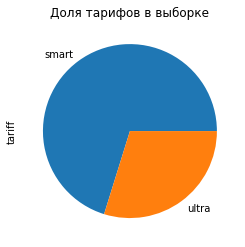

In [38]:
display(users.groupby('tariff')['tariff'].count())
users.groupby('tariff')['tariff'].count().plot(kind='pie', title='Доля тарифов в выборке')

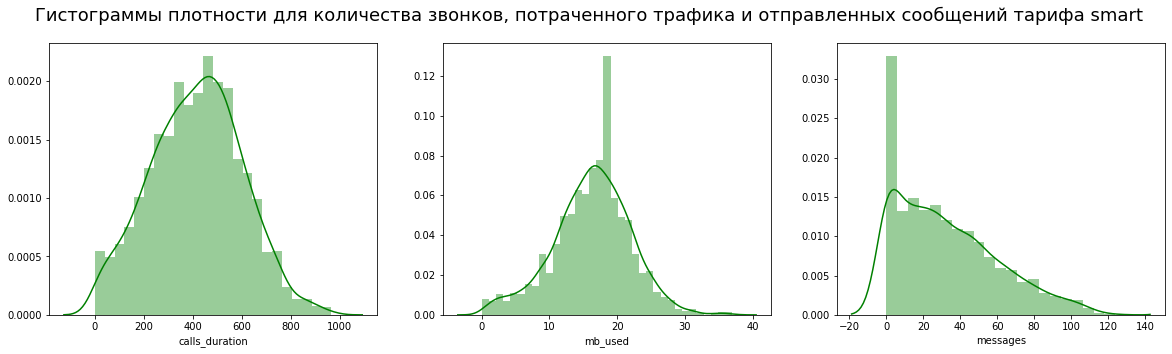

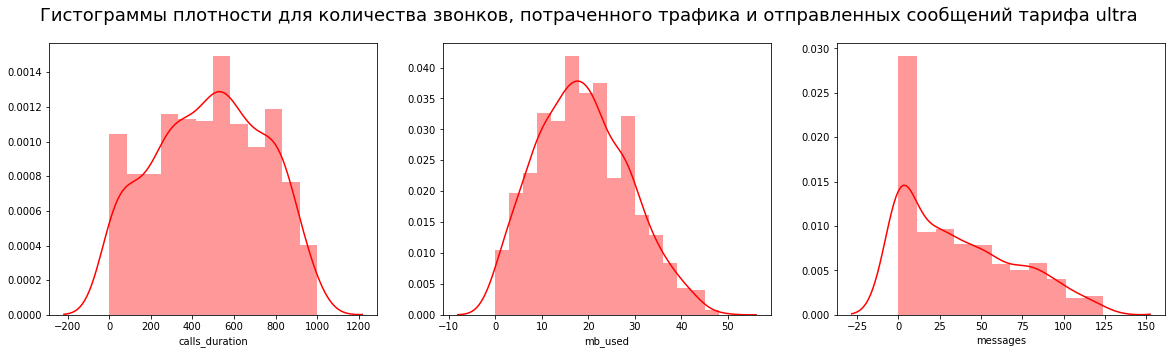

In [39]:
fig, axs = plt.subplots(1,3, figsize=[20,5])
fig.suptitle('Гистограммы плотности для количества звонков, потраченного трафика и отправленных сообщений тарифа smart',fontsize=18)
for i, column in enumerate(columns_list):
    sns.distplot(tarif_smart[column], ax=axs[i], color='green')
    
plt.show()

fig, axs = plt.subplots(1,3, figsize=[20,5])
fig.suptitle('Гистограммы плотности для количества звонков, потраченного трафика и отправленных сообщений тарифа ultra',fontsize=18)
for i, column in enumerate(columns_list):
    sns.distplot(tarif_ultra[column], ax=axs[i], color='red')

#### Вывод

В среднем, пользователи тарифа Ultra разговаривают на час больше, чем те, кто пользуется Smart'ом. Также, Ultra расходует на 1гб трафика больше, чем Smart. Разница в сообщениях незначительна. В остальном, графики обоих тарифов примерно схожи

### Гипотезы 

Выручка компании от каждого тарифа


tariff
smart    1514360
ultra    1614600
Name: earnings, dtype: int64

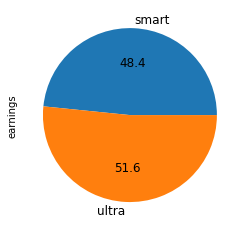

In [40]:
print('Выручка компании от каждого тарифа')
display(tab_filter.groupby('tariff')['earnings'].sum().astype(int))
tab_filter.groupby('tariff')['earnings']\
    .sum().plot.pie(autopct='%.1f', fontsize=12, figsize=(4, 4))
plt.show()

#### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
<b> Первая гипотеза - средняя выручка компании от пользователей тарифов Ultra и Smart различаются. </b>

Проверка двух совокупностей на равенство их средних (st.ttest_ind). Первая совокупность - это пользователи smart, вторая - ultra. В каждой выборке больше 30 наблюдений: можно применить t-критерий. 

Н0 - средняя выручка компании от пользователей тарифов «Ультра» и «Смарт» одинаковая
H1 - средняя выручка компании от пользователей тарифов «Ультра» и «Смарт» отличается

Уровень значимости зададим равным .05

Дисперсии выборок не равны, а значит equal_var = False


In [41]:
alpha = .05
results = st.ttest_ind(tarif_smart['earnings'], tarif_ultra['earnings'], equal_var=False)
print(results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.0
Отвергаем нулевую гипотезу


p-уровень значимости получился крайне маленьким, что свидетельствует о ничтожно малом шансе жизнеспособности нашей нулевой гипотизы о том, что H0 верна и выручки двух тарифов будут равны. H0 отвергается.

In [42]:
print('Средняя выручка компании от тарифа smart - {} '.format(round(tarif_smart['earnings'].describe()[1],
                                                                       )))
print('Выручка компании от тарифа smart - {} '.format(tarif_smart['earnings'].sum()))
print()
print('Средняя выручка компании от тарифа ultra - {} '.format(round(tarif_ultra['earnings'].describe()[1])))
print('Выручка компании от тарифа ultra - {} '.format(tarif_ultra['earnings'].sum()))

Средняя выручка компании от тарифа smart - 684 
Выручка компании от тарифа smart - 1514360 

Средняя выручка компании от тарифа ultra - 1950 
Выручка компании от тарифа ultra - 1614600 


В данном анализе был использован t-критерий. Также проверка гипотезы о равенстве среднего двух генеральных совокупностей проводилась по взятым из них выборкам (на круговой диаграмме выше показано разделение по тарифам). Альтернативная гипотеза заключалась в том, что средняя выручка компании от разных тарифов не равна. 

#### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.


In [43]:
moscow_earnings = tab_filter.loc[tab_filter['city']== 'Москва','earnings'] 
regions_earnings = tab_filter.loc[tab_filter['city'] != 'Москва','earnings'] 
results2 = st.ttest_ind(moscow_earnings, regions_earnings, equal_var=False) #equal_var False потому что
# дисперсии у этих выборок неравны. 
print(results2.pvalue)
if (results2.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.0051281924405379665
Отвергаем нулевую гипотезу


51% вероятность получить результат, что выручка в регионах и в Москве будут одинаковыми. Нулевая гипотеза о том, что выручка отличается, отвергается

### Общий вывод

Данные оказались довольно "чистыми". Единственное, что пришлось - это удалить столбец Unnamed в датасете интернет-трафика, который дублировал индексы.
<br>
<br>
С помощью функции из данных были отобраны выборки, наиболее близкие к нормальному распределению, без выбросов. </br> 
<br>
<br>
Средняя выручка компании от одного пользователя тарифа ultra больше, чем от smart. Кроме того, можно сделать вывод, что пользователи тарифа ultra укладываются в рамки своего тарифного плана и редко доплачивают за доп минуты/трафик/сообщения. Вывод сделан на основании того, что средняя выручка компании примерно равна стоимости пакета.</br>
<br>
<br>
Суммарные же показатели указывают на то, что в нашей выборке больше клиентов с тарифом smart, тем не менее, около 35% процентов всей выручки составляет выручка от тарифа ultra. </br> 
<br>
<br>
СМС оказались непопулярны в двух тарифах. Можно посоветовать компании сократить количество предоставляемых СМС в пользу интернет-трафика, к примеру. </br> 
<br> 
<br>
Среднее выручка у тарифа ultra больше, чем у тарифа smart, и несмотря на то, что в выборке подавляющее большинство занимали пользователи тарифа smart, выручка тарифа ultra не сильно уступала (круговая диаграмма 65% против 35%). Поэтому компании стиот уделить особое внимание тарифу ultra

